# Week 2: Building our first algorithms

### Why trade using algorithms?
1. Time! While one can spend twelve hours a day trading, it's not for everyone. A computer can run twenty four hours a day, running the same algorithm, forever, without a problem.
    - This is espicially true now since crypto is a 24/7 market. 
2. Efficiency! A person trading four hours and hours might get tired or forget their strategies. A computer will run 1:1 with its programming for as long as it's online.
3. Money! Simply put, trading with an algorithm can be better than not trading at all (but it can be worse, so let's be careful). When you have an algorithm that works, it's fire and forget; there's really no maintenance that needs to be done until your strategy stops working.
  
### Parts of a trading algorithm:
1. We need data.  This can be done either through statically defining the assets we want our algorithm to trade on, or we can create a data pipeline, which will dynamically select stocks for us to trade on using a pre-defined selection process.
2. Once our test set is defined, we'll need to create rules such that given some input, our algorithm will decide to buy, hold, or sell our assets.  In a very simple example we can simply purhcase shares of a stock every day, or if we want to be more advanced, we could purchase on moving average crossovers.
3. Our algorithm has to be analyzed using in sample and out of sample testing.  This is likely familiar to anyone with experience in machine learning.  Just like in ML, overfitting is a dangerous game and must be handeled very carefully.  We can analyze our results by tracking returns, sharpe ratio (we'll get to that soon), or a handful of other methods.

### Now let's walk through these steps using a really simple algorithm
For this we're going to use a library called Zipline.  It's a really good way to quickly benchmark ideas and understand performance from a holistic perspective

### A quick note about this notebook: 
If you want to run this notebook you'll likely want to make a new virtual/conda environment because Zipline requires really old packages to run correctly and is not well maintained.  We're using this platform simply because it's probably the best backtester for simple algorithms and to illustrate how to make algorithms of a reasonable complexity without having to build all the code yourself.  

When you start to build more complicated algorithms you really won't be able to use a plug and play backtester like this simply because you'll want scalability in how you build your algorithm and won't want to redesign it simply for testing purposes

In [3]:
from zipline.api import order, symbol
from zipline import run_algorithm

def initialize(algo):
    # this runs once at the start of our algorithm
    # the algo keyword acts as "self"
    algo.stocks = ["AAPL"]
    algo.symbol_ids = [symbol(asset) for asset in algo.stocks]  # symbol just returns a unique id for every US asset
    
def handle_data(algo, data):
    # this runs once per timestep (i.e. if our algo operates on days then this runs once per day)
    # order function takes an asset and a number of shares to purchase
    for asset in algo.symbol_ids:
        order(asset, 1)

### Now we want to test our algorithm

In [4]:
import pandas as pd

start = pd.Timestamp('2016-1-1', tz='utc')
end = pd.Timestamp('2017-1-1', tz='utc')

results = run_algorithm(start=start, end=end, capital_base=10000, initialize=initialize, handle_data=handle_data)
# we feed our initialize and handle_data function to run_algorithm and it runs a backtest between start and end

### Getting our backtest results
We use pyfolio to extract our results from this zipline backtest and it generates a lot of helpful information that speak to our performance

### What to look for
1. Returns tracks how much our investments grew over the term of the test.  Clearly bigger is better
2. Volatility measures in essence the standard deviation of our returns.  To reason about what values are good, consider our ideal situation: we make a lot of money with very little risk.  We can think about risk as the spread of our returns, which would correspond to low volatility.  Thus low volatility is preferred. 


### Def: Sharpe Ratio: 
TODO: talk about sharpe ratio, drawdown, leverage, and exposure

Start date,2016-01-04
End date,2016-12-30
Total months,12
,Backtest
Annual return,-0.2%
Cumulative returns,-0.2%
Annual volatility,0.3%
Sharpe ratio,-0.85
Calmar ratio,-0.69
Stability,0.71
Max drawdown,-0.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.34,2016-01-07,2016-11-18,NaT,NaN
1,0.00,2016-01-04,2016-01-05,2016-01-06,3
2,0.00,2016-01-04,2016-01-04,2016-01-04,1
3,0.00,2016-01-04,2016-01-04,2016-01-04,1
4,0.00,2016-01-04,2016-01-04,2016-01-04,1


Stress Events,mean,min,max
New Normal,-0.00%,-0.13%,0.07%


Top 10 long positions of all time,max
sid,
AAPL,3.45%


Top 10 short positions of all time,max
sid,
AAPL,-4.69%


Top 10 positions of all time,max
sid,
AAPL,4.69%


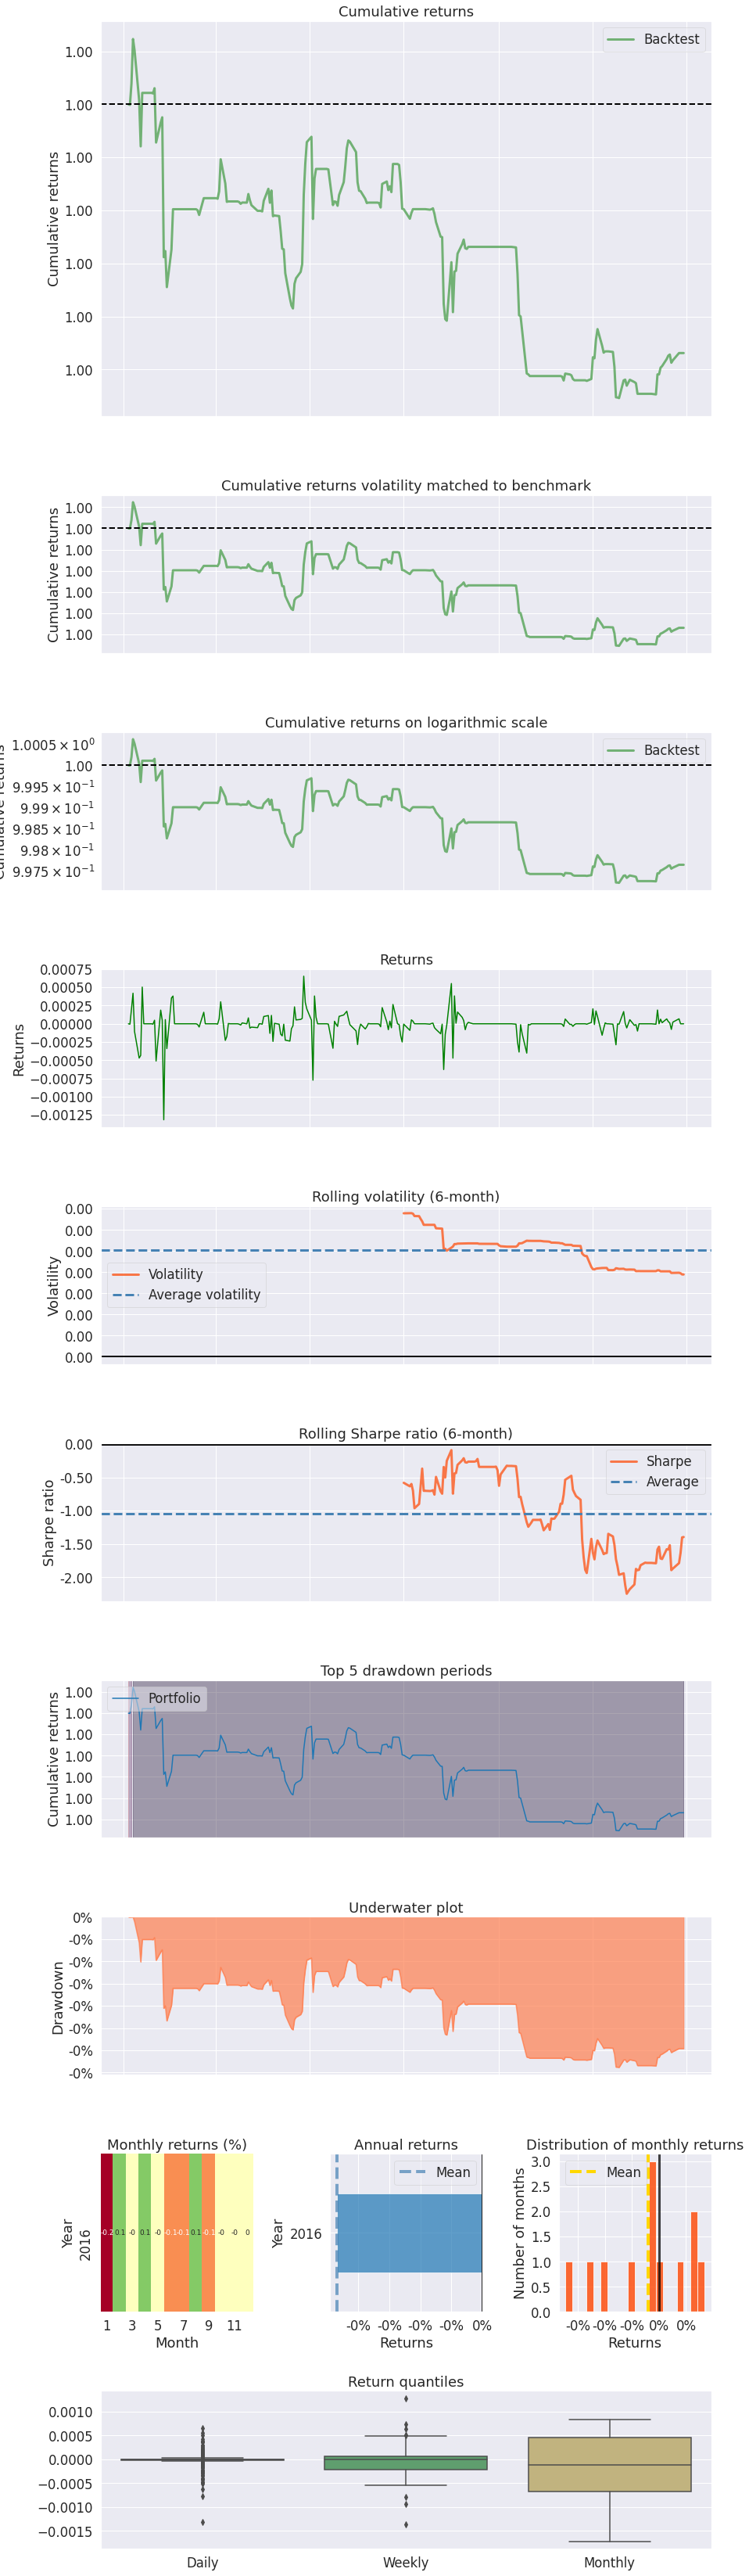

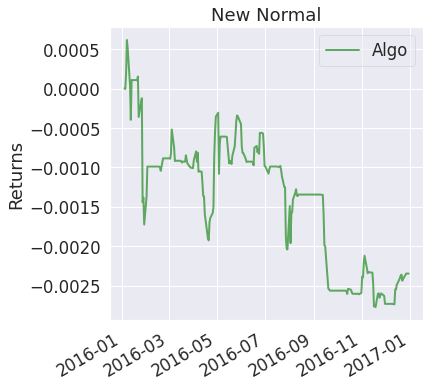

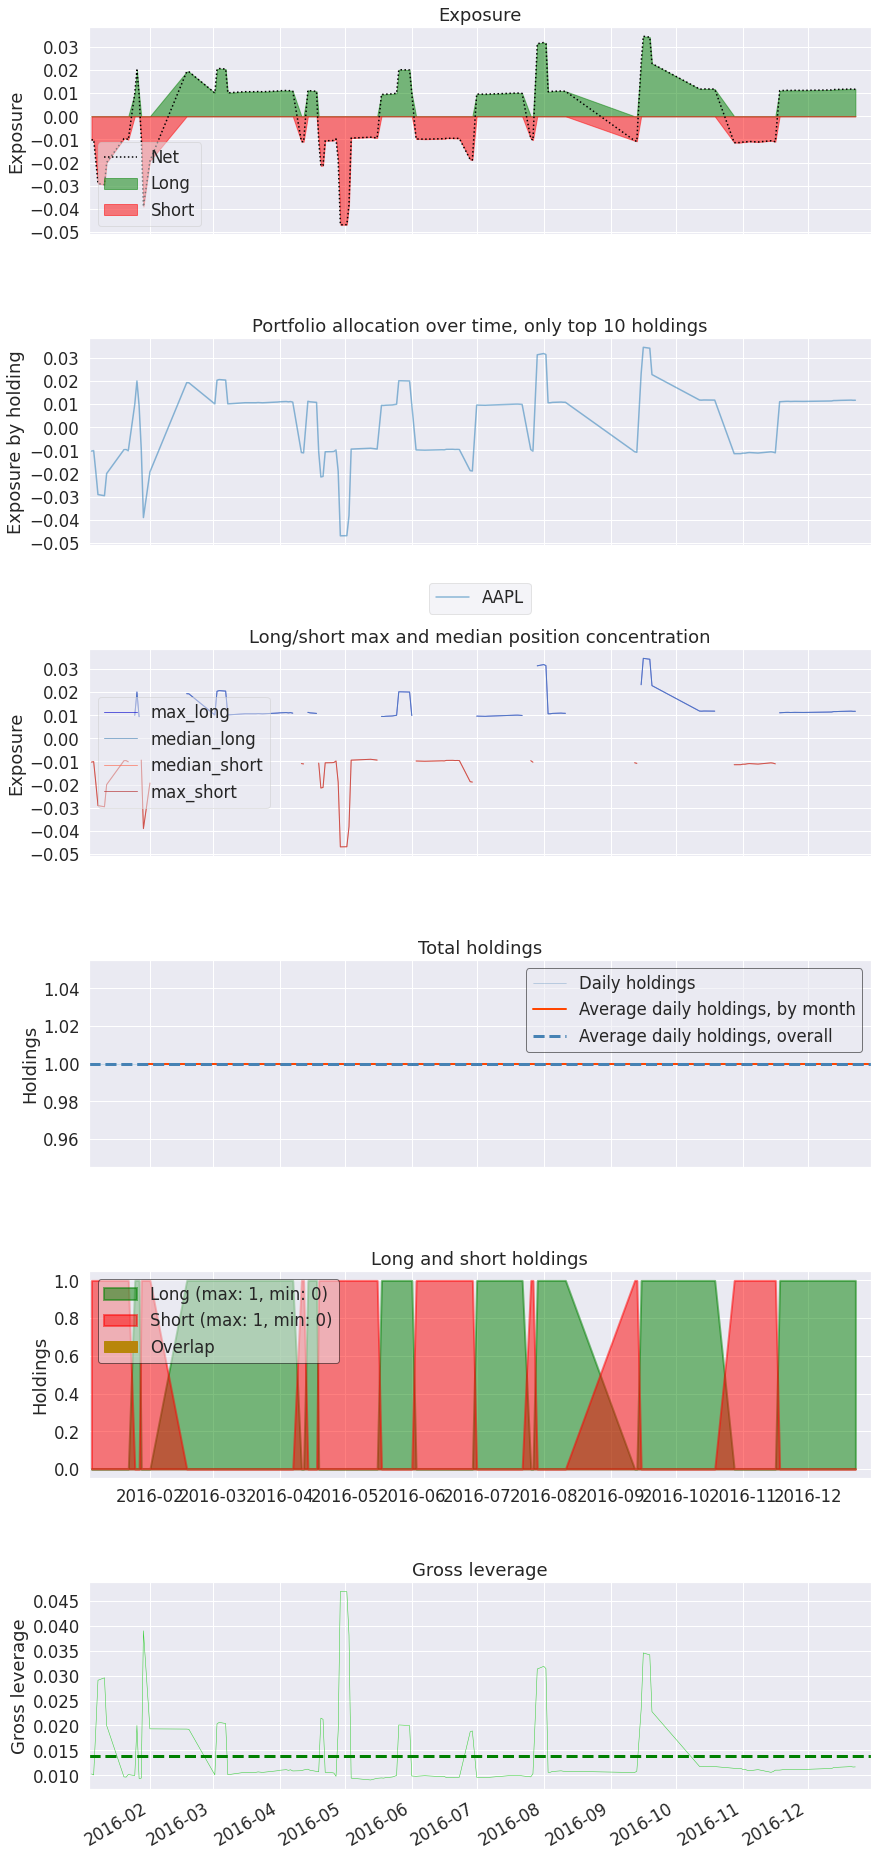

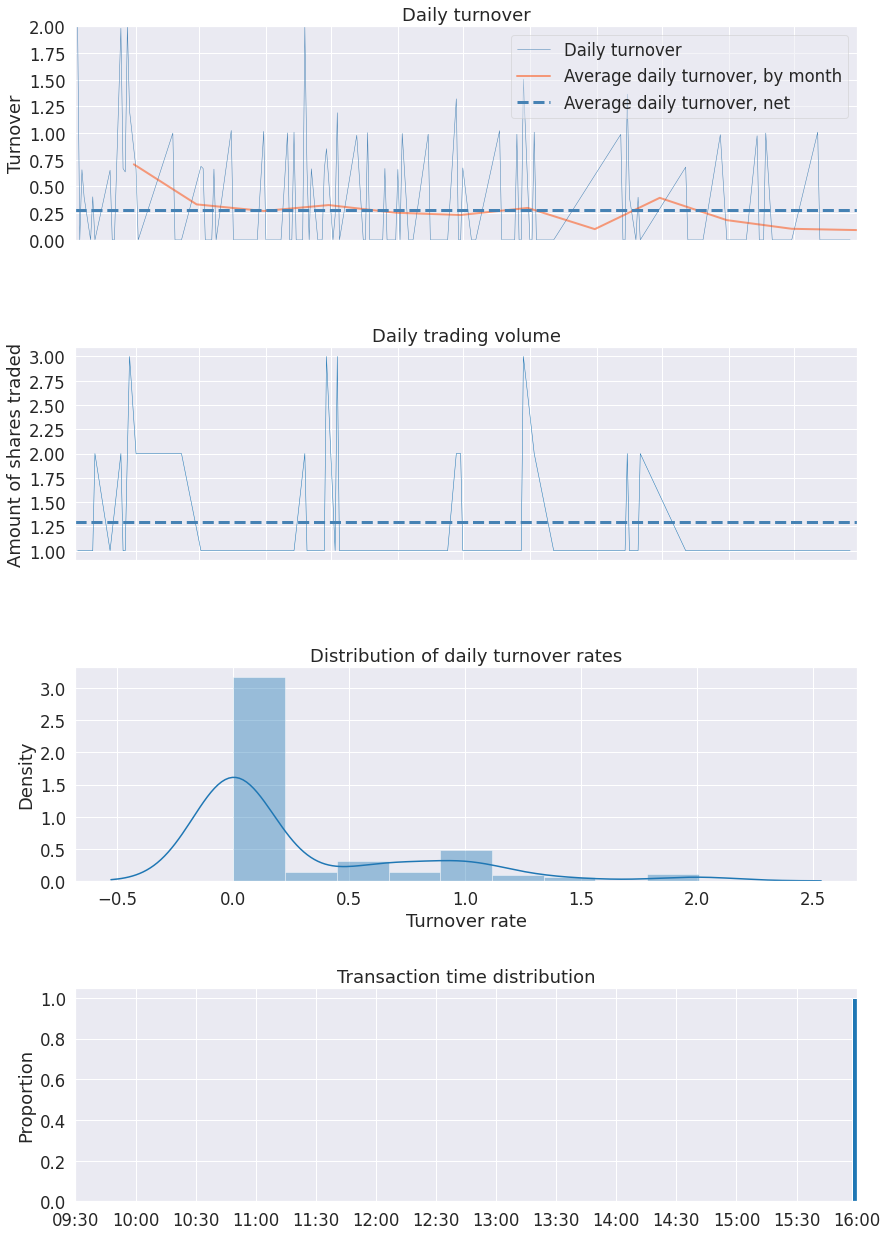

In [8]:
import pyfolio as pf
import warnings
warnings.filterwarnings("ignore")  # since lots of this is old we don't want to see warnings

returns, positions, orders = pf.utils.extract_rets_pos_txn_from_zipline(results)

# a full tear sheet gives all generated information about our performance
pf.create_full_tear_sheet(returns, positions=positions, transactions=orders)

### Key takeaways from this algorithm
We made a good amount of money.  30% is significantly better than usual market returns, but in reality we were doing nothing special in our algorithm.  Buying  1 share of Apple stock every day is not novel.

Although we would have made some money, ideally we want to find less risky and more diverse assets to ensure stable returns in the long run.  Apple's continued success is likely, but certainly not guarenteed.  

### A slightly more complex approach

In [30]:
from zipline.api import order_target_percent, symbol
from zipline import run_algorithm

def initialize(algo):
    # this runs once at the start of our algorithm
    # the algo keyword acts as "self"
    algo.stocks = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']
    algo.symbol_ids = [symbol(asset) for asset in algo.stocks]  # symbol just returns a unique id for every US asset
    

def make_weights(algo, data):
    recent = data.history(assets=algo.symbol_ids, fields='close', bar_count=60, frequency='1d')
    short_mean = recent[-10:].mean()
    long_mean = recent[-50:].mean()
    weights = (short_mean - long_mean) / long_mean
    norm_weights = weights / weights.abs().sum()
    # everyday we'll rebalance our portfolio using the moving averages to generate a normalized investment weight
    return norm_weights


def handle_data(algo, data):
    weights = make_weights(algo, data)
    # this runs once per timestep (i.e. if our algo operates on days then this runs once per day)
    # order function takes an asset and a number of shares to purchase
    for asset in algo.symbol_ids:
        # if we get mean crossover we'll hold the asset for 1 day then dump it 
        order_target_percent(asset, weights[asset])

Start date,2016-01-04
End date,2016-12-30
Total months,12
,Backtest
Annual return,18.5%
Cumulative returns,18.5%
Annual volatility,34.2%
Sharpe ratio,0.66
Calmar ratio,0.84
Stability,0.54
Max drawdown,-21.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.94,2016-08-23,2016-10-20,NaT,NaN
1,20.68,2016-01-04,2016-04-19,2016-05-26,104
2,9.06,2016-06-21,2016-06-27,2016-07-18,20
3,6.71,2016-05-31,2016-06-03,2016-06-17,14
4,5.40,2016-07-26,2016-08-02,2016-08-15,15


Stress Events,mean,min,max
New Normal,0.09%,-6.66%,16.38%


Top 10 long positions of all time,max
sid,
AMD,70.83%
GPS,44.51%
INTC,23.98%
MMM,21.69%
CERN,21.41%
COST,13.67%


Top 10 short positions of all time,max
sid,
GPS,-48.64%
AMD,-44.23%
COST,-43.73%
CERN,-41.38%
MMM,-29.55%
INTC,-26.17%


Top 10 positions of all time,max
sid,
AMD,70.83%
GPS,48.64%
COST,43.73%
CERN,41.38%
MMM,29.55%
INTC,26.17%


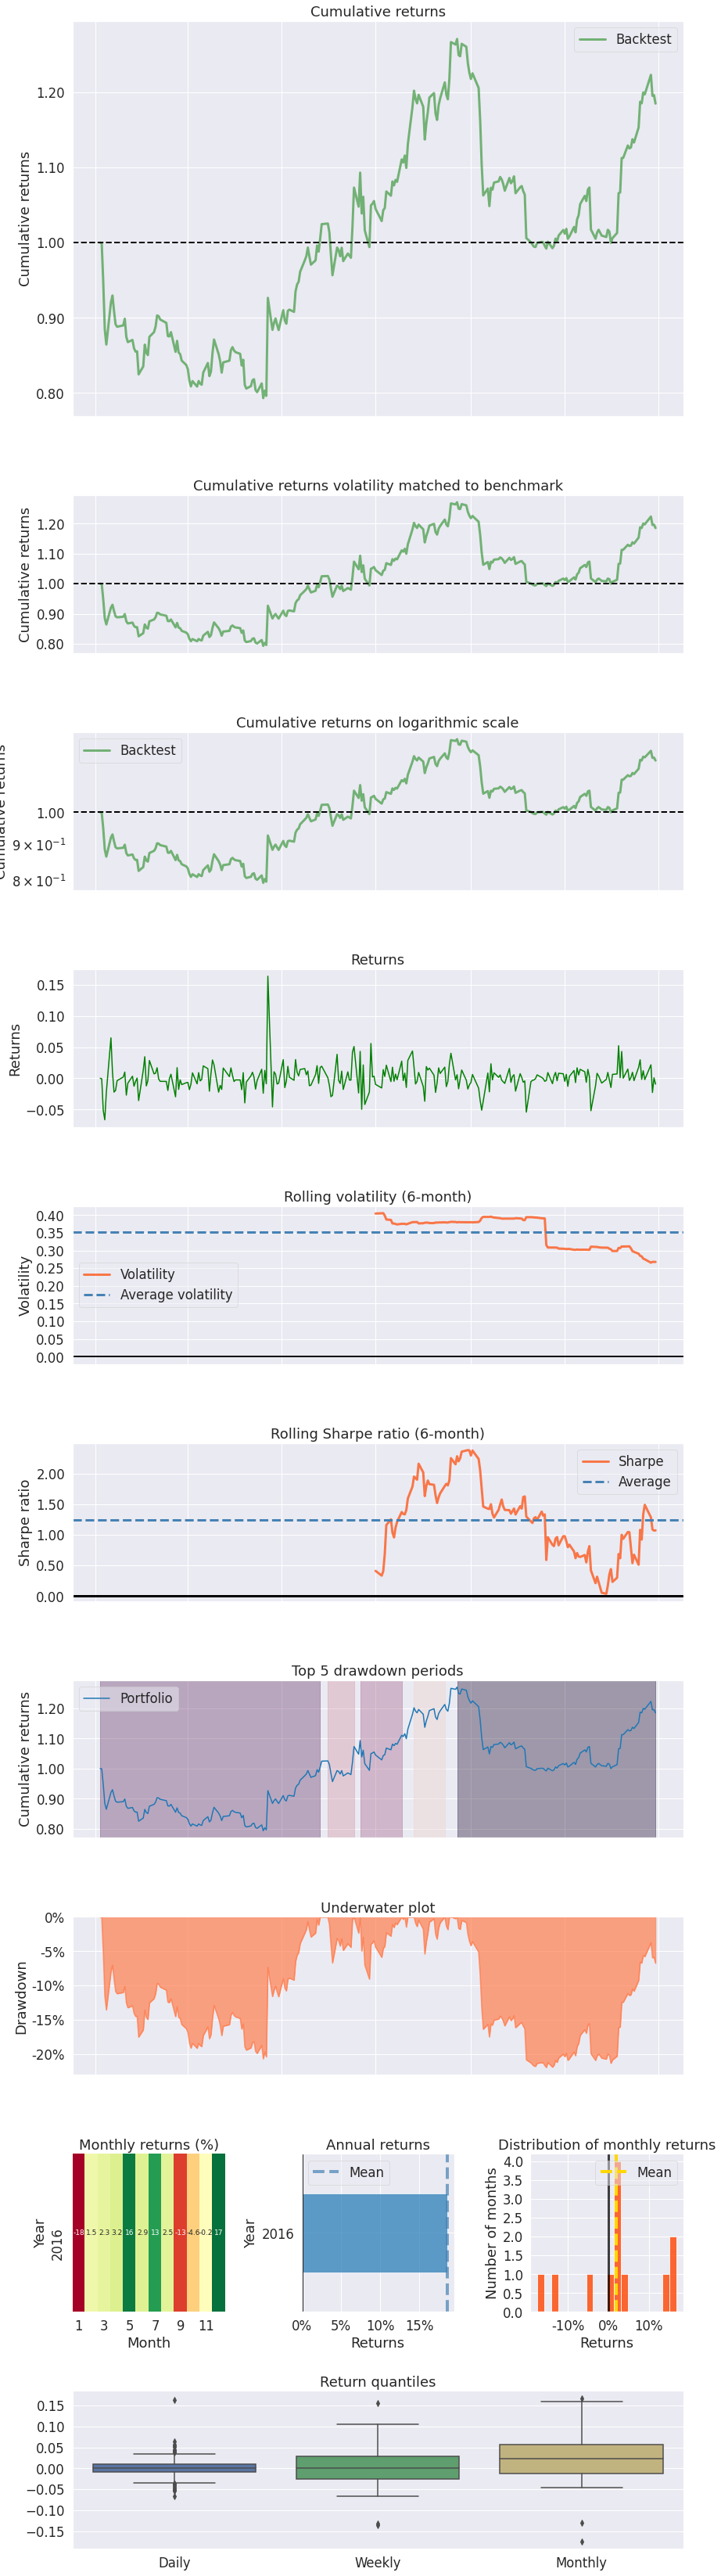

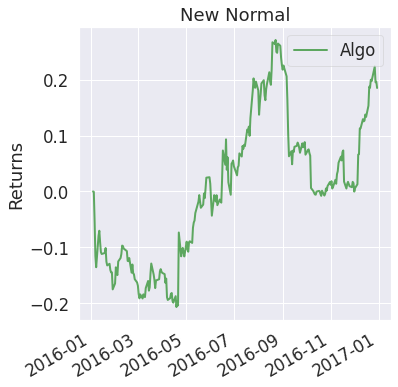

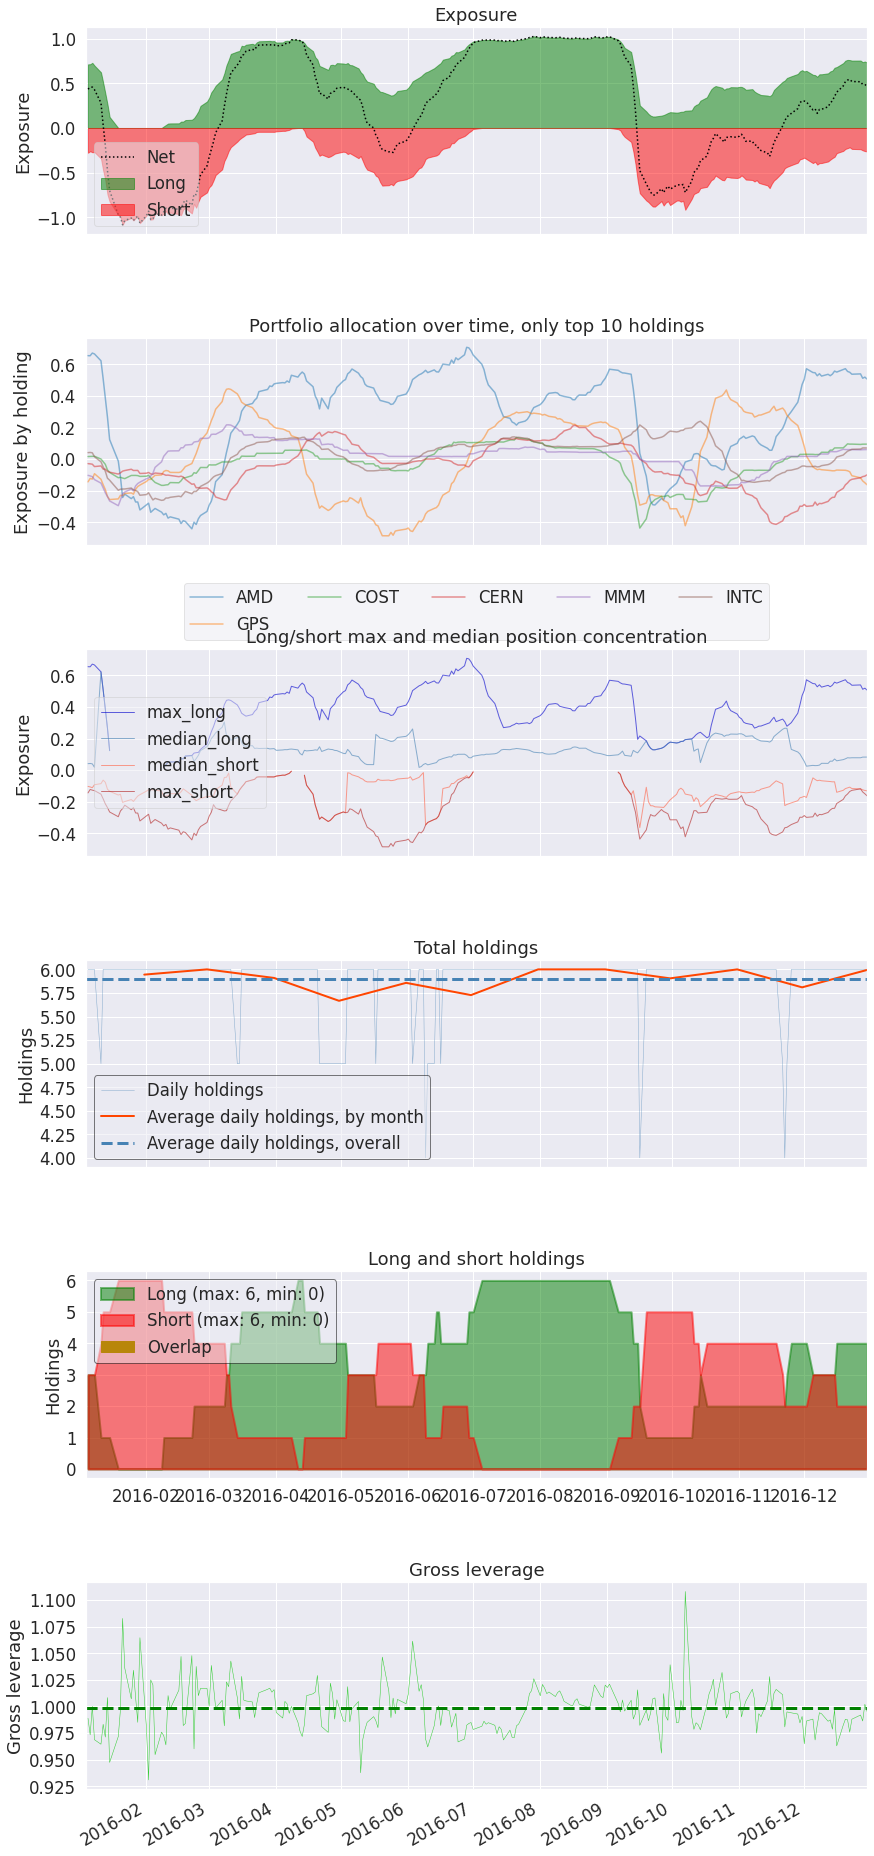

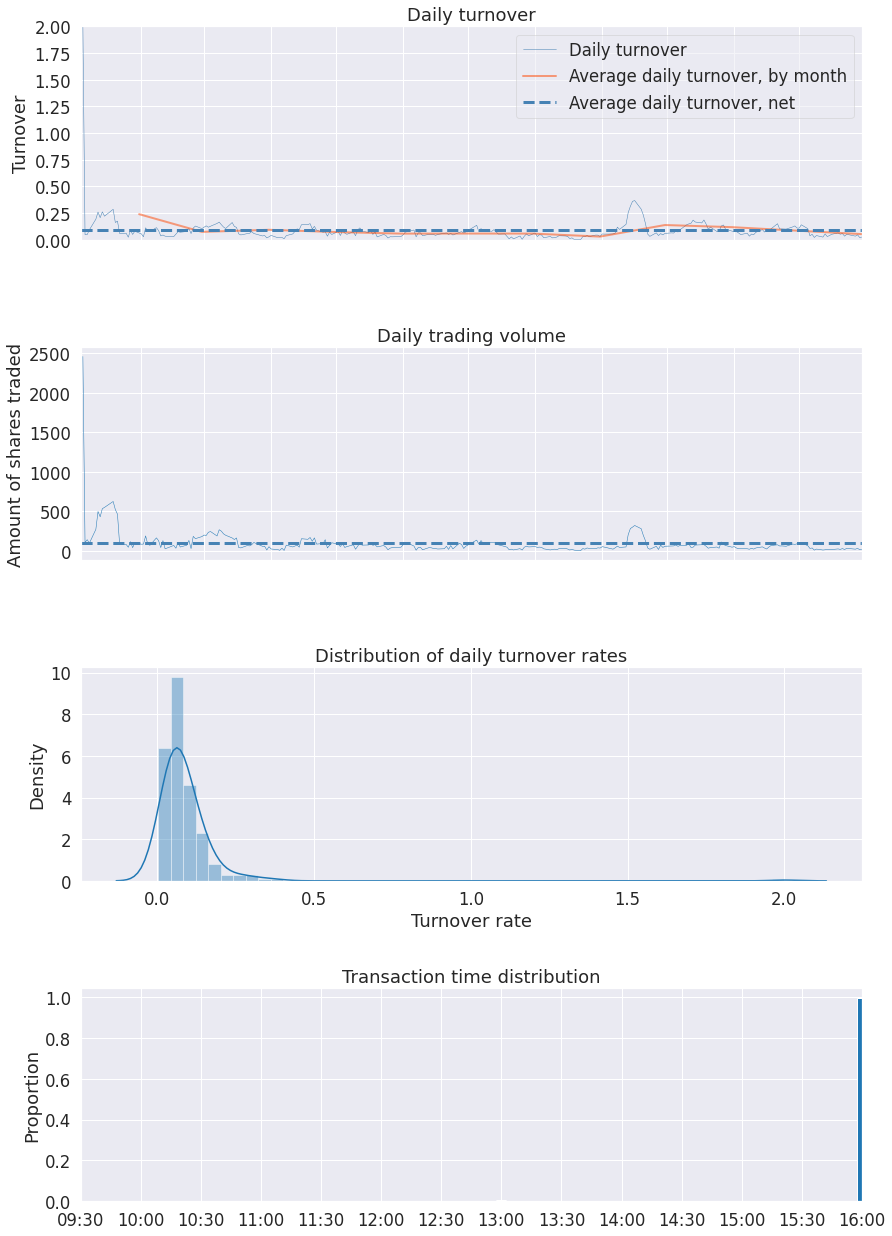

In [31]:
import pandas as pd
import pyfolio as pf
import warnings
warnings.filterwarnings("ignore")

start = pd.Timestamp('2016-1-1', tz='utc')
end = pd.Timestamp('2017-1-1', tz='utc')

results = run_algorithm(start=start, end=end, capital_base=10000, initialize=initialize, handle_data=handle_data)
returns, positions, orders = pf.utils.extract_rets_pos_txn_from_zipline(results)
pf.create_full_tear_sheet(returns, positions=positions, transactions=orders)

### TL;DR: Better, but not really
We do a good job at diversifying with going roughly equally long and short, but we have high volatility and high drawdown.

Now lets try to trade using some technical analysis indicators.  RSI is a good example.  

In [53]:
from zipline.api import order_target_percent, symbol
from zipline import run_algorithm
from ta.momentum import RSIIndicator  

def initialize(algo):
    # this runs once at the start of our algorithm
    # the algo keyword acts as "self"
    algo.stocks = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']
    algo.symbol_ids = [symbol(asset) for asset in algo.stocks]  # symbol just returns a unique id for every US asset
    algo.has_positions = {asset: False for asset in algo.symbol_ids}


def technicals(algo, data):
    recent = data.history(assets=algo.symbol_ids, fields='close', bar_count=15, frequency='1d')
    rsi_values = {}
    for asset in algo.symbol_ids:
        rsi = RSIIndicator(recent[asset], window=14) # compute 14 day RSI
        rsi_values[asset] = rsi.rsi()[-1]  # each day we'll update with a new rsi value
    return rsi_values


def handle_data(algo, data):
    rsi = technicals(algo, data)
    for asset in algo.symbol_ids:
        if rsi[asset] > 75 and not algo.has_positions[asset]:  
            # overbought, would expect price correction downwards (ie short asset)
            order_target_percent(asset, -5)
            algo.has_positions[asset] = True
        if rsi[asset] < 25 and not algo.has_positions[asset]:  
            # oversold, would expect price correction upwards
            order_target_percent(asset, 5)
            algo.has_positions[asset] = True
        if 45 < rsi[asset] < 55 and algo.has_positions[asset]: 
            # price moves to middle - liquidate position for hopefully a profit
            order_target_percent(asset, 0)
            algo.has_positions[asset] = False

In [ ]:
import pandas as pd
import pyfolio as pf
import warnings
warnings.filterwarnings("ignore")

start = pd.Timestamp('2016-1-1', tz='utc')
end = pd.Timestamp('2017-1-1', tz='utc')

results = run_algorithm(start=start, end=end, capital_base=10000, initialize=initialize, handle_data=handle_data)
returns, positions, orders = pf.utils.extract_rets_pos_txn_from_zipline(results)
pf.create_full_tear_sheet(returns, positions=positions, transactions=orders)

### Wow, that was bad
Our knowledge of how the RSI behaves does not correspond to market success.  This is relatively easy to see since a stock could go up on the long term and still not necessarily mean revert (which is basically what we're betting on).  This is espicially true on our longer term scale of 1 day increments.  Such a strategy would only have a chance of working on lower frequency data since long term market trends usually disappear on such a short frequency.

### Lets Try Something Different - Backtrader Library

In [7]:
from datetime import datetime
import backtrader as bt

class SMACross(bt.Strategy):
    params = dict(
        fast=10,
        slow=50
        )
    
    def __init__(self):
        sma_fast = bt.ind.SMA(period=self.params.fast)
        sma_slow = bt.ind.SMA(period=self.params.slow)
        self.signal = bt.ind.CrossOver(sma_fast, sma_slow)
        
    def next(self):
        if not self.position: # not in market
            if self.signal > 0:  # fast sma crosses above slow sma
                self.buy(size=60)  # enter long
                
        elif self.signal < 0:  # fast sma crosses below slow sma 
            self.close() # close signal

<IPython.core.display.Javascript object>


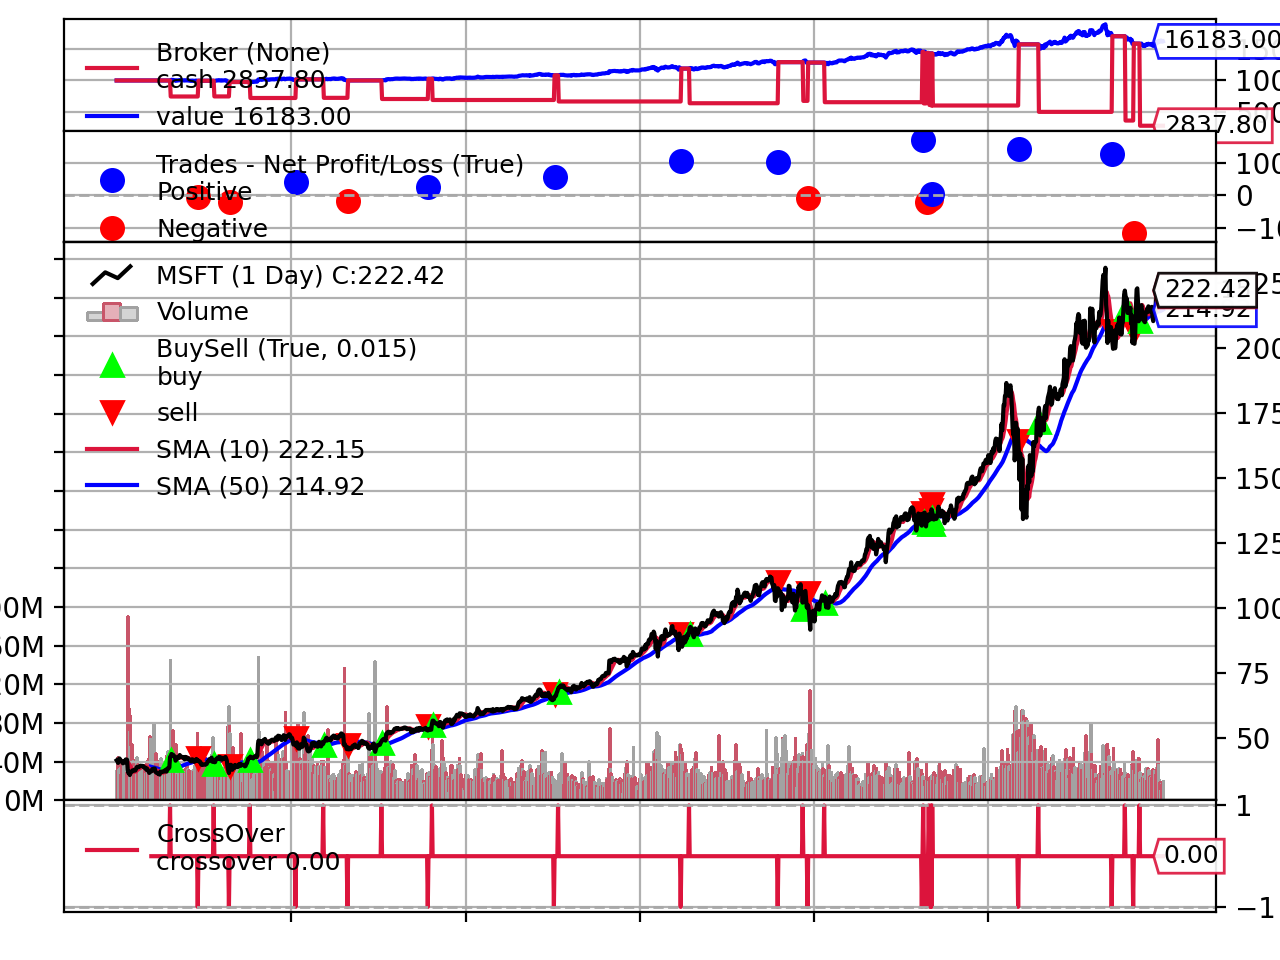

final value:  16182.999999999996


In [8]:
cerebro = bt.Cerebro()

data = bt.feeds.YahooFinanceData(dataname='MSFT',
                                 fromdate=datetime(2015, 1, 1),
                                 todate=datetime(2021, 1, 1))
cerebro.adddata(data)

cerebro.addstrategy(SMACross)

cerebro.run()
cerebro.plot()
print("final value: ", cerebro.broker.getvalue())

### BUY THE DIP (haha jk, unless):

Stock goes down x days in a row, hold for a few days and hope there's a rebound.

Warren Buffet has a quote about being fearful when others are greedy, and being greedy when others are fearful.  The idea is generally that large cap stocks have a near certainty of rebounding after some number of days.  This is very sound advice for long term investing since we're basically getting more stock for our dollar during a significant dip, so we'll see if it holds true on a shorter scale. 

In [18]:
from datetime import datetime
import backtrader as bt

class BuyDip(bt.Strategy):
    def __init__(self):
        self.close = self.datas[0].close
        self.order = None
        self.buy_amount = 60
        self.params = {"hold_days": 5}  # days we hold the stock before selling - regardless of price
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None
    
    def next(self):
        # do nothing if in order
        if self.order:
            return 
        
        # check non empty position list
        if not self.position:
            # can access previous days using negative indexing
            if self.close[0] < self.close[-1] < self.close[-2]:
                self.order = self.buy(size=self.buy_amount)
                   # print("BUY: ", self.close[0])
        else:
            if len(self) >= self.bar_executed + self.params["hold_days"]:
                    self.order = self.sell(size=self.buy_amount)
                    # print("SELL: ", self.close[0], '\n')

<IPython.core.display.Javascript object>


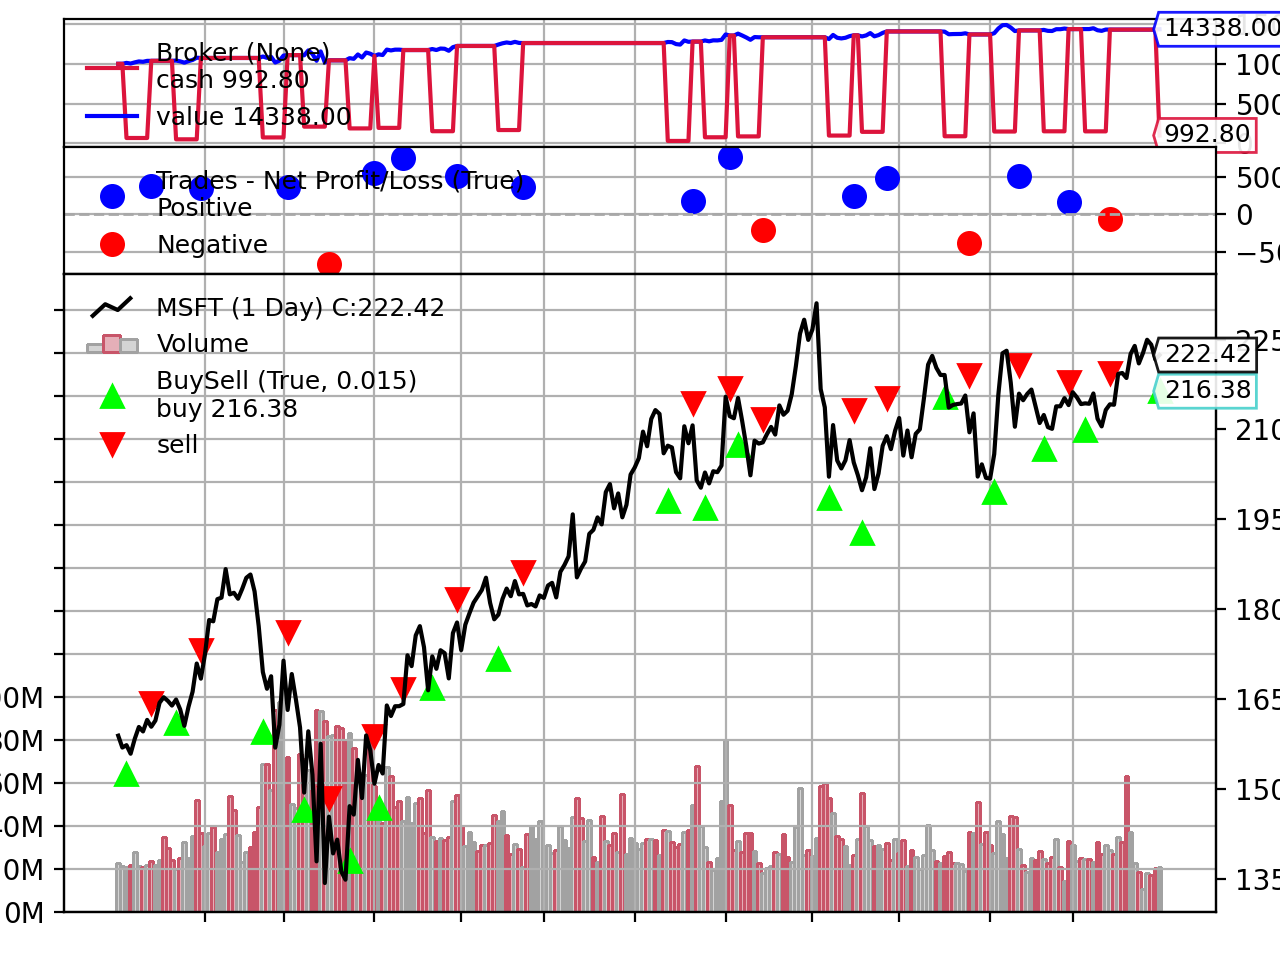

percent change: 43.37999999999996%


In [28]:
cerebro = bt.Cerebro()

data = bt.feeds.YahooFinanceData(dataname='MSFT',
                                 fromdate=datetime(2020, 1, 1),
                                 todate=datetime(2021, 1, 1))
cerebro.adddata(data)

cerebro.addstrategy(BuyDip)

start = cerebro.broker.getvalue()  # start with 10k

cerebro.run()
cerebro.plot()

end = cerebro.broker.getvalue()  # final value of portfolio

pct_change = (end - start) / start

print(f"percent change: {pct_change*100}%")

This is a pretty good strategy.  We're up 40%, which is pretty respectable considering the market was pretty bad overall this year.  However we should also check other years and other stocks as well.  We'd also want much more statistics to actually understand our strategy, but luckily for us we can integrate Pyfolio with Backtrader.

### Out of Sample Testing

We developed our algorithm on 2020, so it would be wise to also test it on a previous year to make sure we actually have a good idea and didn't just get lucky.  

<IPython.core.display.Javascript object>


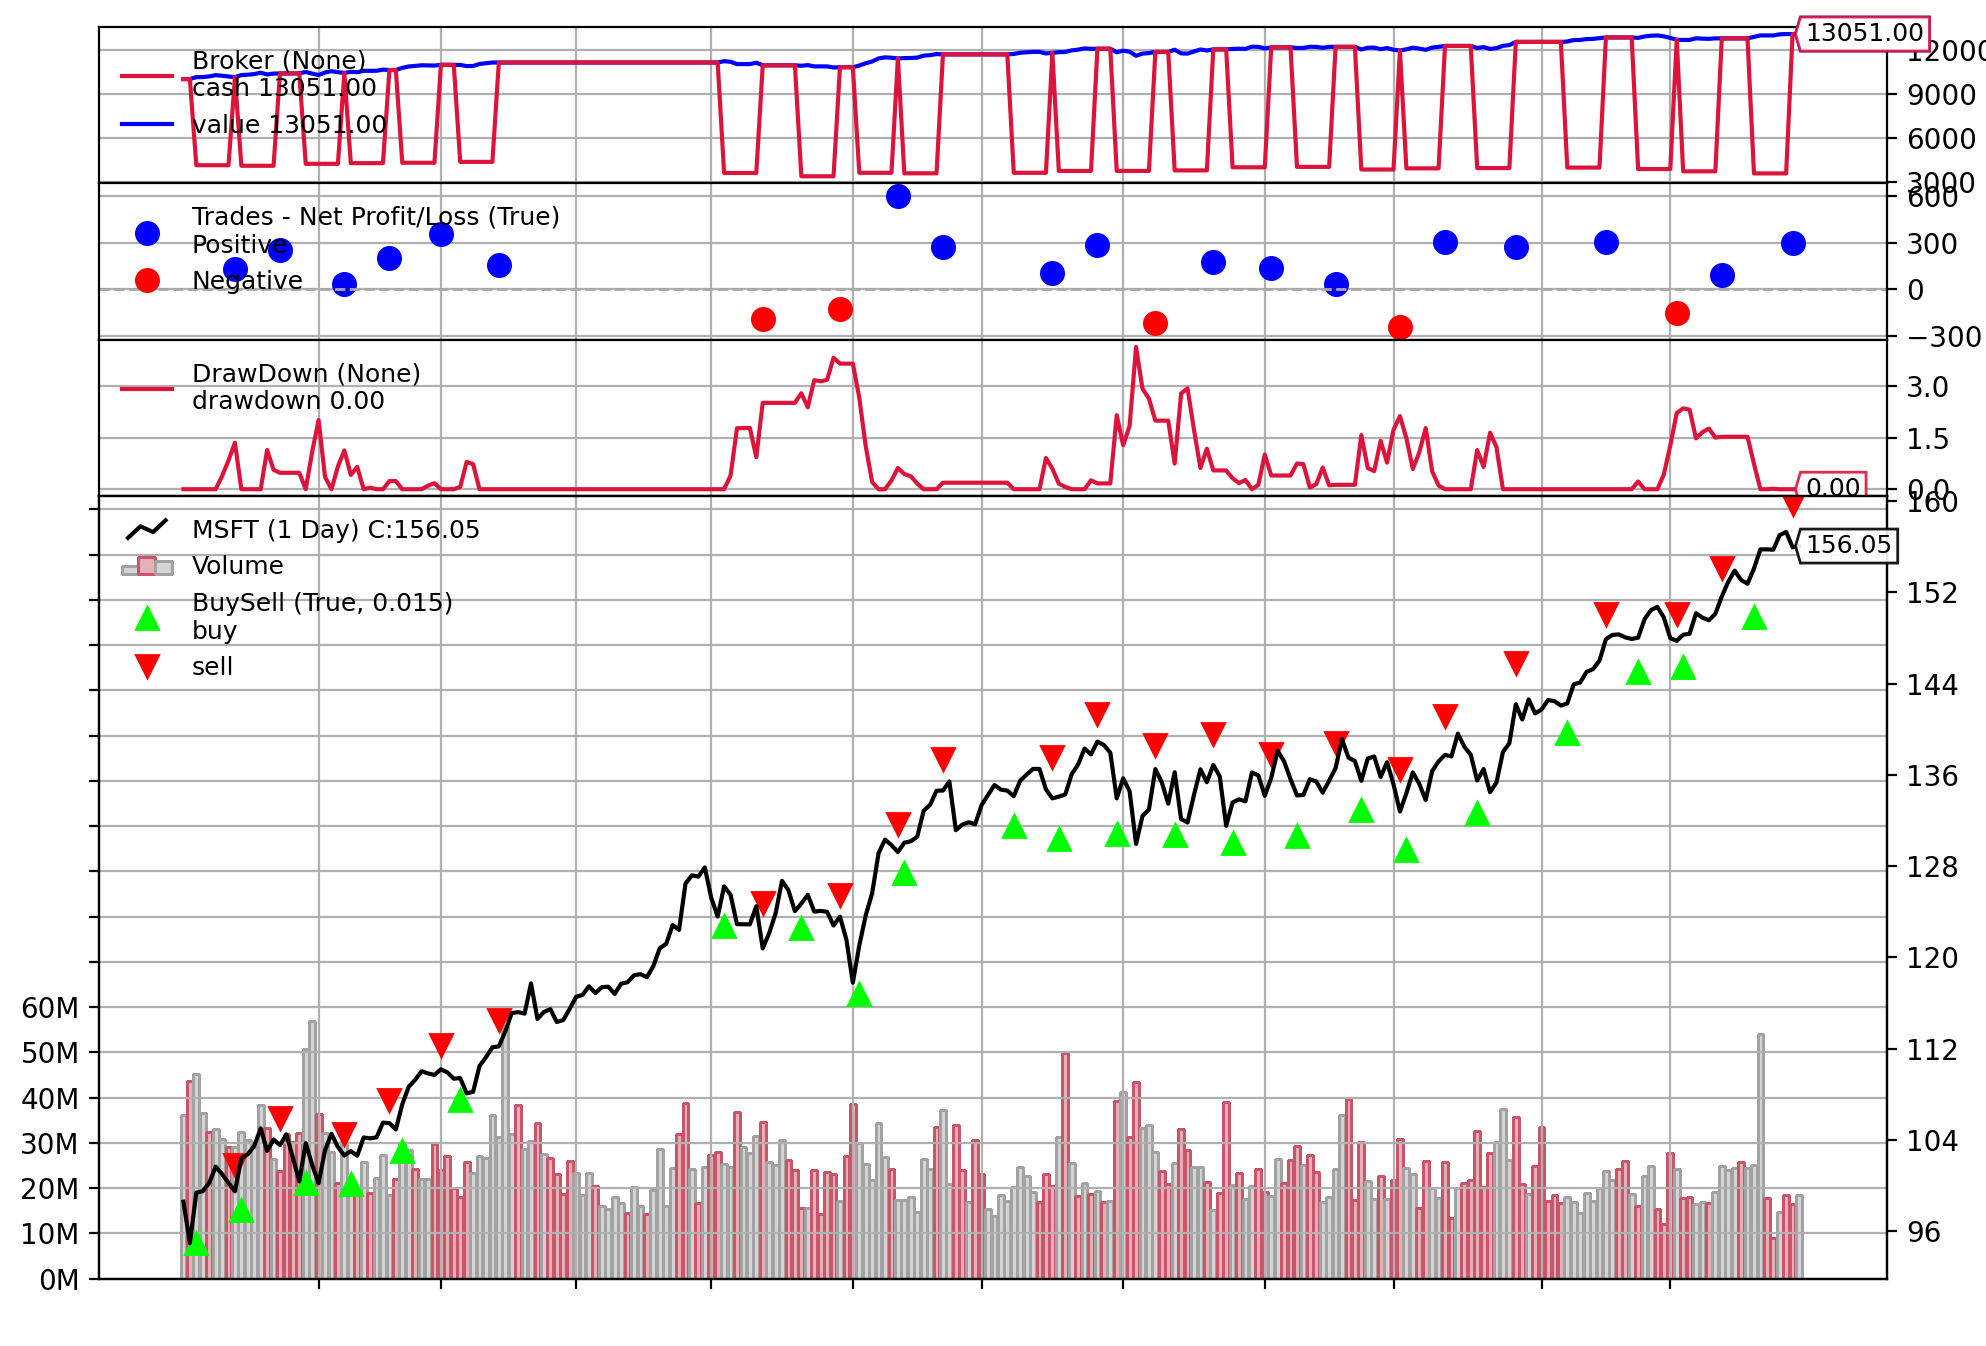

percent change: 30.51%


In [44]:
import pyfolio as pf
cerebro = bt.Cerebro()

data = bt.feeds.YahooFinanceData(dataname='MSFT',
                                 fromdate=datetime(2019, 1, 1),
                                 todate=datetime(2020, 1, 1))
cerebro.adddata(data)

cerebro.addstrategy(BuyDip)

cerebro.addobserver(bt.observers.DrawDown)

start = cerebro.broker.getvalue()  # start with 10k

results = cerebro.run()
cerebro.plot()

end = cerebro.broker.getvalue()  # final value of portfolio

pct_change = (end - start) / start

print(f"percent change: {round(pct_change*100, 3)}%")

30% is still pretty good.  We also have less than 5% drawdown, which means whenever we're underwater it isn't a significant drop.  Under 10% is an ideal max drawdown number.  

We still didn't outperform the buy and hold strategy.  If we bought at USD 98, which is where it was at the start of the year, then it closed at USD 156, which is a 59 percent return, almost 20 percent more than our strategy.  Take home message is that it's very difficult to beat the benchmark.  

We did however beat the market in 2020 testing though, so we might make the conclusion that this strategy works best in bearish markets with uncertainty, since in a strong market you won't likely be able to beat the buy and hold strategy.